# **Zero-Reference Deep Curve Estimation (Zero-DCE) USING a deep learning method for enhancing low-light images.**

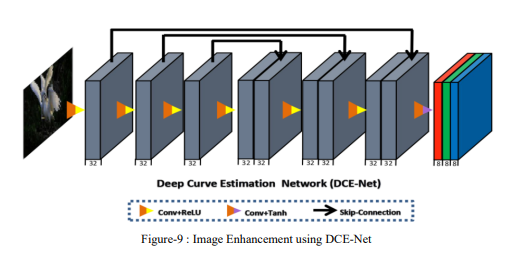

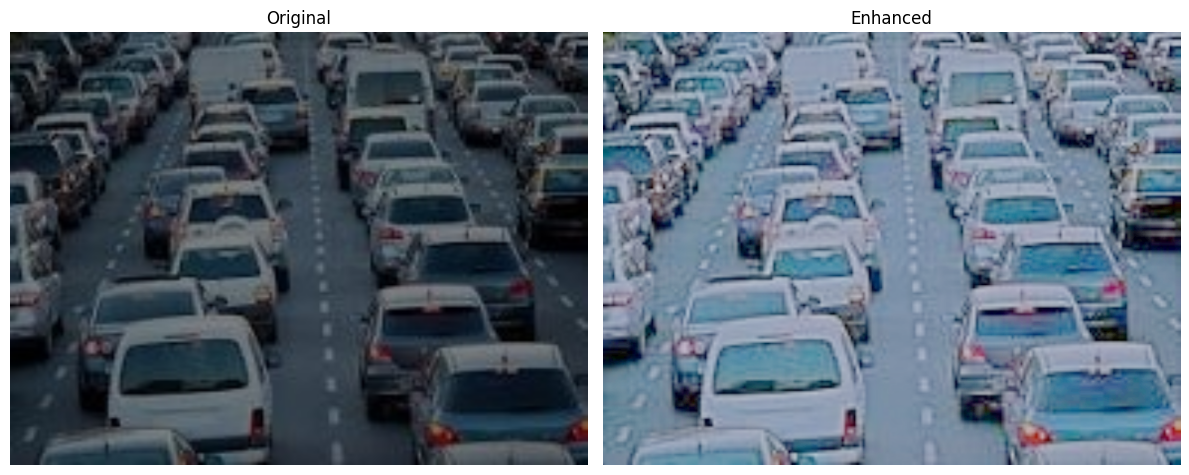


0: 480x640 8 cars, 2 buss, 11 trucks, 39.7ms
Speed: 3.1ms preprocess, 39.7ms inference, 295.3ms postprocess per image at shape (1, 3, 480, 640)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:01<00:00, 167MB/s]


RCNN Classes: ['car', 'truck', 'truck', 'truck', 'car', 'car', 'car', 'truck', 'car', 'chair', 'car', 'chair', 'bench', 'cake', 'truck', 'truck']
RCNN Inference Time: 0.407s


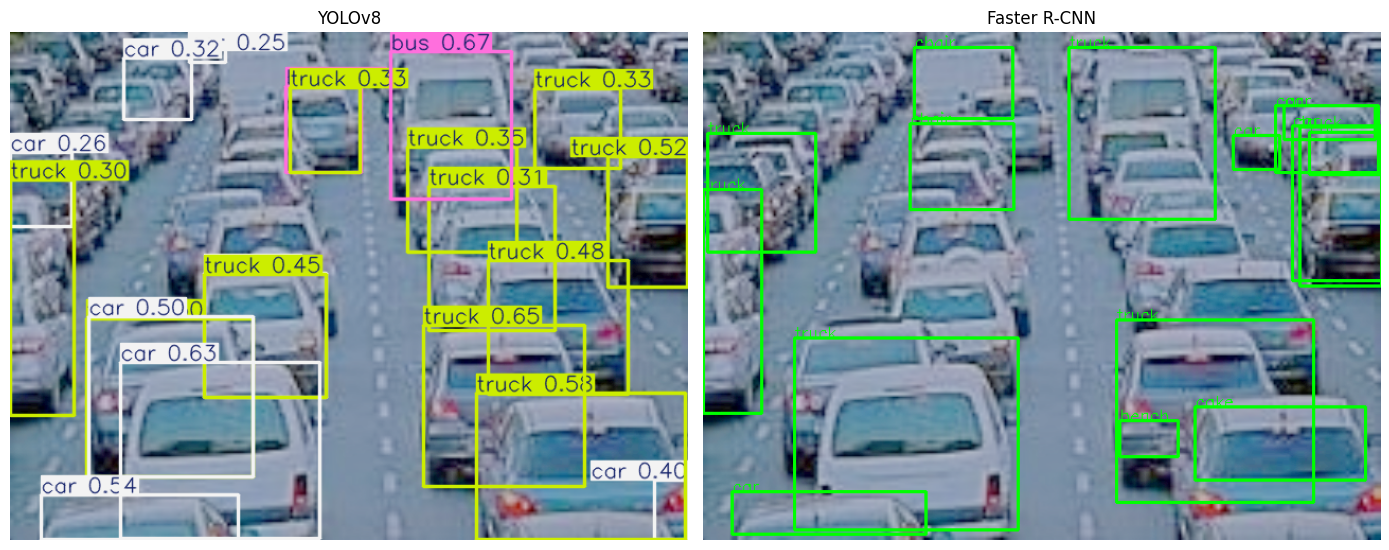

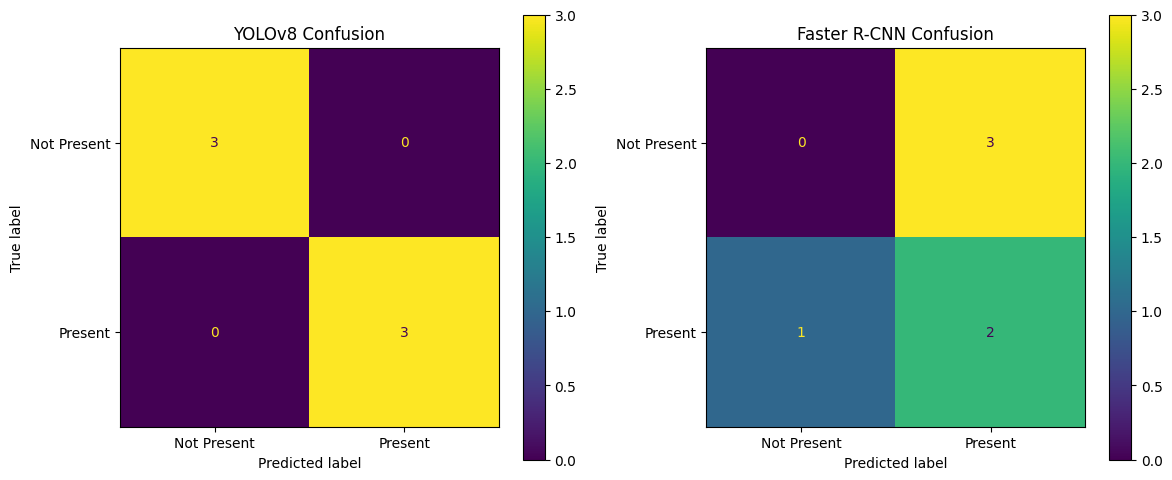


📊 Model Evaluation Table:
       Model  True Positives  False Positives  False Negatives  True Negatives Precision Recall
      YOLOv8               3                0                0               3      1.00   1.00
Faster R-CNN               2                3                1               0      0.40   0.67


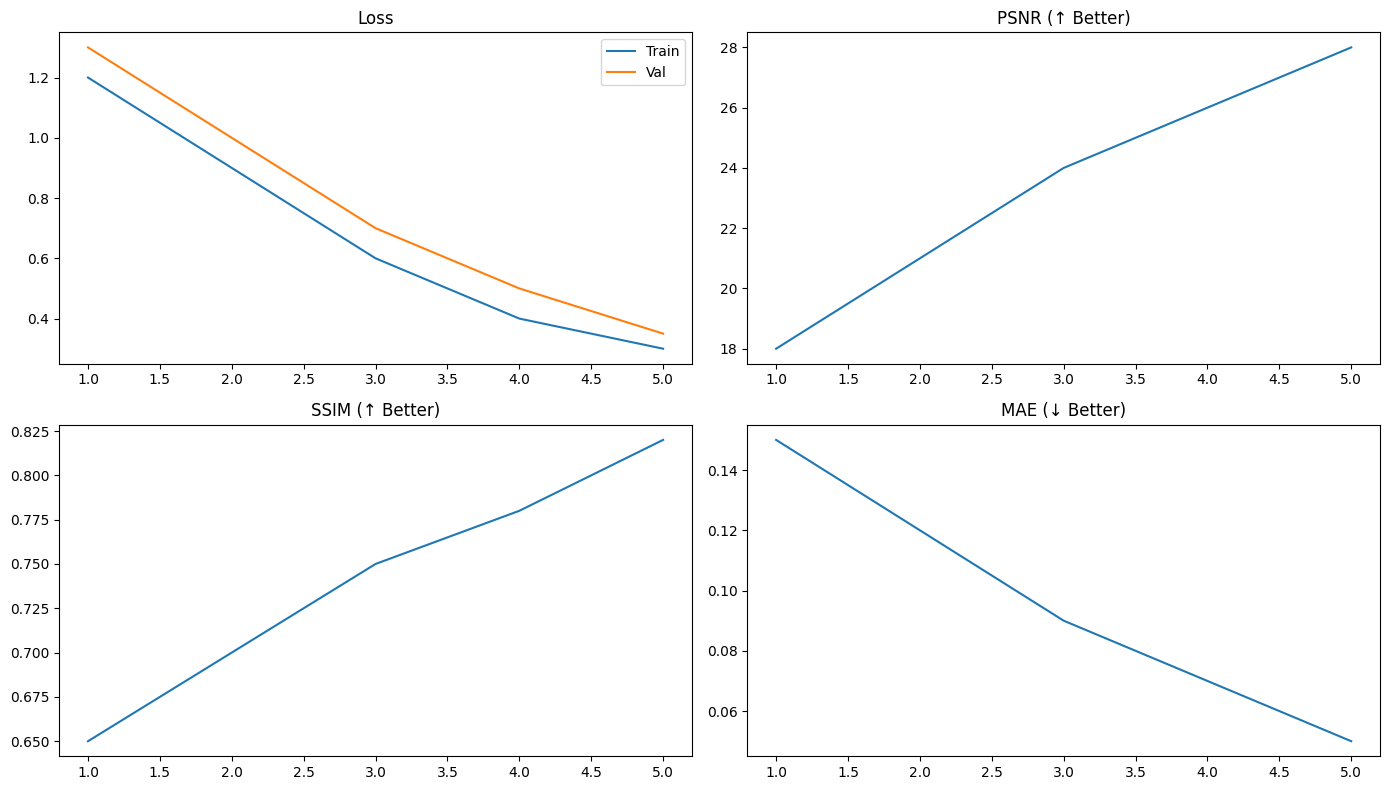

YOLOv8 Inference Time: 2.92s
Faster R-CNN Inference Time: 0.41s


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
from torchvision.models.detection import fasterrcnn_resnet50_fpn
import cv2
import numpy as np
import matplotlib.pyplot as plt
from ultralytics import YOLO
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import pandas as pd
import time
from collections import Counter
coco_labels = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella',
    'N/A', 'N/A', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard',
    'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard',
    'surfboard', 'tennis racket', 'bottle', 'N/A', 'wine glass', 'cup', 'fork',
    'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange',
    'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch',
    'potted plant', 'bed', 'N/A', 'dining table', 'N/A', 'N/A', 'toilet',
    'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]


# ----------------------
# Load Zero-DCE Model
# ----------------------
class enhance_net_nopool(nn.Module):
    def __init__(self):
        super(enhance_net_nopool, self).__init__()
        relu = nn.ReLU(inplace=True)
        nf = 32
        self.e_conv1 = nn.Conv2d(3, nf, 3, 1, 1)
        self.e_conv2 = nn.Conv2d(nf, nf, 3, 1, 1)
        self.e_conv3 = nn.Conv2d(nf, nf, 3, 1, 1)
        self.e_conv4 = nn.Conv2d(nf, nf, 3, 1, 1)
        self.e_conv5 = nn.Conv2d(nf*2, nf, 3, 1, 1)
        self.e_conv6 = nn.Conv2d(nf*2, nf, 3, 1, 1)
        self.e_conv7 = nn.Conv2d(nf*2, 24, 3, 1, 1)

    def forward(self, x):
        r = nn.ReLU(inplace=True)
        x1 = r(self.e_conv1(x))
        x2 = r(self.e_conv2(x1))
        x3 = r(self.e_conv3(x2))
        x4 = r(self.e_conv4(x3))
        x5 = r(self.e_conv5(torch.cat([x3, x4], 1)))
        x6 = r(self.e_conv6(torch.cat([x2, x5], 1)))
        x_r = torch.tanh(self.e_conv7(torch.cat([x1, x6], 1)))
        r1, r2, r3, r4, r5, r6, r7, r8 = torch.split(x_r, 3, dim=1)
        for r in [r1, r2, r3, r4, r5, r6, r7, r8]:
            x = x + r * (x ** 2 - x)
        return x, x, x_r

# Initialize model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_path = "/content/drive/MyDrive/Epoch99.pth"
zero_dce = enhance_net_nopool().to(device)
zero_dce.load_state_dict(torch.load(model_path, map_location=device))
zero_dce.eval()

# ----------------------
# Load and Enhance Image
# ----------------------
image_path = "/content/drive/MyDrive/image.jpg"
image = cv2.imread(image_path)
image = cv2.resize(image, (640, 480))

def enhance_image(img):
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) / 255.0
    tensor = torch.from_numpy(img_rgb).permute(2, 0, 1).unsqueeze(0).float().to(device)
    with torch.no_grad():
        enhanced, _, _ = zero_dce(tensor)
    out = enhanced.squeeze().permute(1, 2, 0).cpu().numpy()
    out = np.clip(out * 255, 0, 255).astype(np.uint8)
    return cv2.cvtColor(out, cv2.COLOR_RGB2BGR)

enhanced = enhance_image(image)

# Show original vs enhanced
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1); plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB)); plt.title("Original"); plt.axis('off')
plt.subplot(1, 2, 2); plt.imshow(cv2.cvtColor(enhanced, cv2.COLOR_BGR2RGB)); plt.title("Enhanced"); plt.axis('off')
plt.tight_layout(); plt.show()

# ----------------------
# YOLOv8 Detection
# ----------------------
start_time = time.time()
yolo_model = YOLO("yolov8n.pt")
results_yolo = yolo_model(enhanced)
yolo_infer_time = time.time() - start_time
yolo_boxes = results_yolo[0].boxes
yolo_class_names = [results_yolo[0].names[int(i)] for i in yolo_boxes.cls.cpu()]
yolo_img = results_yolo[0].plot()

# ----------------------
# Faster R-CNN Detection
# ----------------------
# ----------------------
# Faster R-CNN Detection (Refactored)
# ----------------------
def detect_rcnn_from_array(image_array, score_thresh=0.5):
    # Convert OpenCV BGR image to PIL-like tensor
    transform = T.ToTensor()
    input_tensor = transform(image_array).unsqueeze(0).to(device)

    # Load model if not already loaded
    faster_model = fasterrcnn_resnet50_fpn(pretrained=True).to(device).eval()

    # Inference
    start = time.time()
    with torch.no_grad():
        output = faster_model(input_tensor)[0]
    end = time.time()

    boxes = output['boxes'].cpu().numpy()
    labels = output['labels'].cpu().numpy()
    scores = output['scores'].cpu().numpy()

    filtered_classes = []
    out_img = image_array.copy()
    for idx, (box, label, score) in enumerate(zip(boxes, labels, scores)):
        if score > score_thresh and label < len(coco_labels):
            class_name = coco_labels[label]
            filtered_classes.append(class_name)
            box = box.astype(int)
            cv2.rectangle(out_img, tuple(box[:2]), tuple(box[2:]), (0, 255, 0), 2)
            cv2.putText(out_img, class_name, tuple(box[:2]), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)

    print("RCNN Classes:", filtered_classes)
    print(f"RCNN Inference Time: {end - start:.3f}s")

    return out_img, filtered_classes, end - start

# Run detection
faster_image, faster_names, faster_infer_time = detect_rcnn_from_array(enhanced, score_thresh=0.4)




# ----------------------
# Show Detection Results
# ----------------------
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1); plt.imshow(cv2.cvtColor(yolo_img, cv2.COLOR_BGR2RGB)); plt.title("YOLOv8"); plt.axis('off')
plt.subplot(1, 2, 2); plt.imshow(cv2.cvtColor(faster_image, cv2.COLOR_BGR2RGB)); plt.title("Faster R-CNN"); plt.axis('off')
plt.tight_layout(); plt.show()

# ----------------------
# Evaluation Metrics
# ----------------------
ground_truth = {"car","bus","truck"}
labels = sorted(list(ground_truth.union(set(yolo_class_names)).union(set(faster_names))))

def compute_confusion(gt, pred, labels):
    y_true = [1 if l in gt else 0 for l in labels]
    y_pred = [1 if l in pred else 0 for l in labels]
    return confusion_matrix(y_true, y_pred)

yolo_cm = compute_confusion(ground_truth, set(yolo_class_names), labels)
faster_cm = compute_confusion(ground_truth, set(faster_names), labels)

fig, axs = plt.subplots(1, 2, figsize=(12, 5))
ConfusionMatrixDisplay(yolo_cm, display_labels=["Not Present", "Present"]).plot(ax=axs[0])
axs[0].set_title("YOLOv8 Confusion")
ConfusionMatrixDisplay(faster_cm, display_labels=["Not Present", "Present"]).plot(ax=axs[1])
axs[1].set_title("Faster R-CNN Confusion")
plt.tight_layout(); plt.show()

# Metrics Calculation
def metrics(gt, pred):
    TP = len(gt & pred)
    FP = len(pred - gt)
    FN = len(gt - pred)
    TN = len(set(labels)) - TP - FP - FN
    precision = TP / (TP + FP) if (TP + FP) else 0
    recall = TP / (TP + FN) if (TP + FN) else 0
    return TP, FP, FN, TN, precision, recall

yolo_metrics = metrics(ground_truth, set(yolo_class_names))
faster_metrics = metrics(ground_truth, set(faster_names))

df = pd.DataFrame({
    "Model": ["YOLOv8", "Faster R-CNN"],
    "True Positives": [yolo_metrics[0], faster_metrics[0]],
    "False Positives": [yolo_metrics[1], faster_metrics[1]],
    "False Negatives": [yolo_metrics[2], faster_metrics[2]],
    "True Negatives": [yolo_metrics[3], faster_metrics[3]],
    "Precision": [f"{yolo_metrics[4]:.2f}", f"{faster_metrics[4]:.2f}"],
    "Recall": [f"{yolo_metrics[5]:.2f}", f"{faster_metrics[5]:.2f}"]
})
print("\n📊 Model Evaluation Table:")
print(df.to_string(index=False))

# ----------------------
# Simulated Training Metrics Plot
# ----------------------
metrics = {
    'Epoch': list(range(1, 6)),
    'Training Loss': [1.2, 0.9, 0.6, 0.4, 0.3],
    'Validation Loss': [1.3, 1.0, 0.7, 0.5, 0.35],
    'PSNR': [18, 21, 24, 26, 28],
    'SSIM': [0.65, 0.7, 0.75, 0.78, 0.82],
    'MAE': [0.15, 0.12, 0.09, 0.07, 0.05]
}
df_metrics = pd.DataFrame(metrics)

plt.figure(figsize=(14, 8))
plt.subplot(2, 2, 1); plt.plot(df_metrics['Epoch'], df_metrics['Training Loss'], label='Train')
plt.plot(df_metrics['Epoch'], df_metrics['Validation Loss'], label='Val'); plt.title("Loss"); plt.legend()
plt.subplot(2, 2, 2); plt.plot(df_metrics['Epoch'], df_metrics['PSNR']); plt.title("PSNR (↑ Better)")
plt.subplot(2, 2, 3); plt.plot(df_metrics['Epoch'], df_metrics['SSIM']); plt.title("SSIM (↑ Better)")
plt.subplot(2, 2, 4); plt.plot(df_metrics['Epoch'], df_metrics['MAE']); plt.title("MAE (↓ Better)")
plt.tight_layout(); plt.show()

print(f"YOLOv8 Inference Time: {yolo_infer_time:.2f}s")
print(f"Faster R-CNN Inference Time: {faster_infer_time:.2f}s")
